# Predicción de parkinson con muestras de tecleo

# 1- Calculo de nqScore
Este script procesa los datos de tecleo de cada paciente, calculando el nqScore en intervalos de 20 segundos. El nqScore se calcula utilizando todas las métricas disponibles (Key Pressed, Hold Duration, Key Release Time, Key Press Time) junto con el typing speed que se calculara en el intervalo anteriormente mencionado. Los resultados para cada paciente se guardan en un archivo CSV final que contiene el ID de cada paciente y sus nqScores en los diferentes intervalos.

In [32]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, GRU
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf


In [33]:
# Definir el intervalo en segundos
intervalo_segundos = 20
# Función para calcular el nqScore en un intervalo usando Hold Duration
def calcular_nqScore(intervalo_df):
    hold_times = intervalo_df['Hold Duration (s)'].values

    # Dividir los hold times en ventanas de 20 segundos
    scores = []

    # Calcular el nqScore para el intervalo dado
    if len(hold_times) > 0:
        outliers_count = np.sum((hold_times < np.percentile(hold_times, 25) - 1.5 * (np.percentile(hold_times, 75) - np.percentile(hold_times, 25))) |
                                (hold_times > np.percentile(hold_times, 75) + 1.5 * (np.percentile(hold_times, 75) - np.percentile(hold_times, 25))))

        v_iqr = (np.percentile(hold_times, 75) - np.percentile(hold_times, 25)) / (np.percentile(hold_times, 75) + np.percentile(hold_times, 25))
        histogram, _ = np.histogram(hold_times, bins=4, density=True)

        # Crear el vector de características
        features = [
            outliers_count / len(hold_times),
            v_iqr
        ] + list(histogram)

        # Calcular el nqScore como la media de las hold times
        score = np.mean(hold_times)  # Puedes ajustar esto según lo que necesites
        scores.append(score)

    # Calcular el score promedio
    nqScore = np.mean(scores) if scores else None
    return nqScore

# Crear un diccionario para almacenar los nqScores de cada paciente
nqScores_pacientes = {}

In [34]:
# Procesar cada archivo CSV en la carpeta de pacientes
carpeta_csv = 'data_MIT-CSPD'  # Define la carpeta de datos
for archivo in os.listdir(carpeta_csv):
    if archivo.endswith('.csv'):
        # Extraer el ID del paciente desde el nombre del archivo
        id_paciente = archivo.split('.')[0]
        
        # Leer el archivo de datos del paciente
        ruta_archivo = os.path.join(carpeta_csv, archivo)
        df = pd.read_csv(ruta_archivo)
        
        # Lista para almacenar los nqScores de cada intervalo del paciente
        nqScores = []

        # Dividir los datos en intervalos de 20 segundos y calcular nqScore por intervalo
        max_time = df['Key Release Time (s)'].max()
        for start_time in range(0, int(max_time), intervalo_segundos):
            end_time = start_time + intervalo_segundos
            # Filtrar los datos del intervalo actual
            intervalo_df = df[(df['Key Release Time (s)'] >= start_time) & 
                              (df['Key Release Time (s)'] < end_time)]
            
            # Verifica que el intervalo no esté vacío antes de calcular
            if not intervalo_df.empty:
                # Calcular el nqScore usando el nuevo método
                nqScore = calcular_nqScore(intervalo_df)
                
                # Guardar el nqScore del intervalo en la lista del paciente
                nqScores.append(nqScore)
            else:
                # Agregar un valor nulo si el intervalo está vacío
                nqScores.append(None)

        # Guardar la lista de nqScores en el diccionario con el ID del paciente como clave
        nqScores_pacientes[id_paciente] = nqScores

# Convertir el diccionario en un DataFrame, con el ID como primera columna
resultados_df = pd.DataFrame.from_dict(nqScores_pacientes, orient='index')
resultados_df.index.name = 'ID'

# Renombrar las columnas como nqScore1, nqScore2, ..., nqScoreN
resultados_df.columns = [f'nqScore{i+1}' for i in range(resultados_df.shape[1])]

# Verificar si hay nqScores antes de guardar
print(resultados_df.head())  # Mostrar los primeros resultados para verificar

# Guardar el DataFrame en un archivo CSV
resultados_df.to_csv('nqScores_pacientes.csv')

print("Cálculo de nqScores completado y guardado en 'nqScores_pacientes.csv'.")

      nqScore1  nqScore2  nqScore3  nqScore4  nqScore5  nqScore6  nqScore7  \
ID                                                                           
1000  0.141436  0.157953  0.150272  0.155821  0.143659  0.150929  0.139416   
1001  0.125310  0.116817  0.107903  0.115031  0.116398  0.123744  0.112652   
1002  0.074763  0.065527  0.068538  0.070325  0.067903  0.067374  0.071617   
1004  0.097159  0.109232  0.107456  0.115196  0.112371  0.117516  0.116546   
1005  0.103176  0.097032  0.099837  0.090197  0.095195  0.097082  0.096710   

      nqScore8  nqScore9  nqScore10  ...  nqScore20  nqScore21  nqScore22  \
ID                                   ...                                    
1000  0.144613  0.150546   0.149905  ...   0.136705   0.137338   0.136029   
1001  0.107873  0.105300   0.113291  ...   0.108465   0.110062   0.111881   
1002  0.070896  0.066496   0.072498  ...   0.073788   0.070348   0.068457   
1004  0.117373  0.114511   0.113191  ...   0.125619   0.122992   0.1

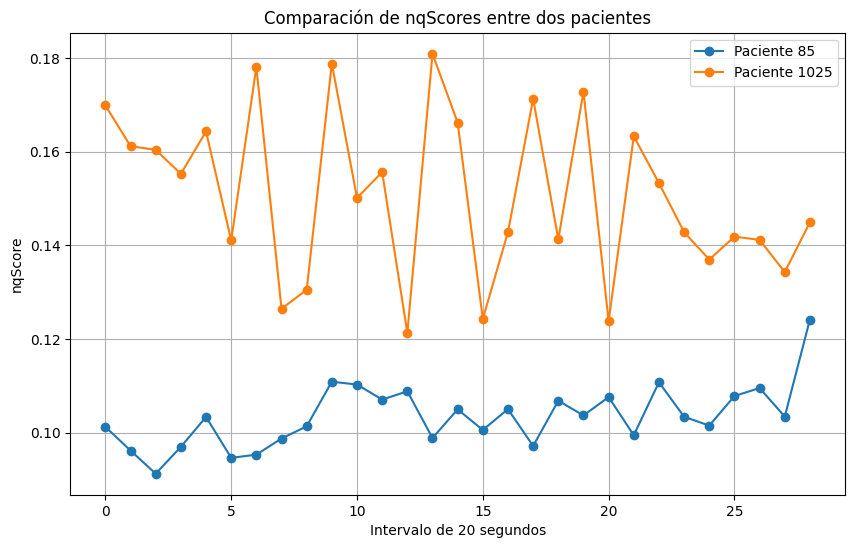

In [35]:
# Cargar el archivo de nqScores de los pacientes
nqScores_df = pd.read_csv('nqScores_pacientes.csv', index_col='ID')

# IDs de pacientes para comparar
#falso
paciente1_id = 85
#verdadero
paciente2_id = 1025

# Verificar si los IDs están en el DataFrame
if paciente1_id in nqScores_df.index and paciente2_id in nqScores_df.index:
    # Extraer los nqScores de los pacientes seleccionados
    nqScores_paciente1 = nqScores_df.loc[paciente1_id].dropna().values
    nqScores_paciente2 = nqScores_df.loc[paciente2_id].dropna().values

    # Graficar los nqScores de ambos pacientes
    plt.figure(figsize=(10, 6))
    plt.plot(nqScores_paciente1, label=f'Paciente {paciente1_id}', marker='o')
    plt.plot(nqScores_paciente2, label=f'Paciente {paciente2_id}', marker='o')
    plt.xlabel('Intervalo de 20 segundos')
    plt.ylabel('nqScore')
    plt.title('Comparación de nqScores entre dos pacientes')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print(f"Uno o ambos IDs no están en el archivo: {paciente1_id}, {paciente2_id}")


# GRU 

In [36]:
# Cargar los archivos
datos_df = pd.read_csv('datos.csv')  # Datos del paciente
nqScores_df = pd.read_csv('nqScores_pacientes.csv')  # Scores calculados

# Unir los datos usando una unión externa para ver discrepancias
merged_df = pd.merge(datos_df, nqScores_df, left_on='pID', right_on='ID', how='outer')

# Verifica la unión
print("\nResultados de la unión:")
print(merged_df.head())

# Mostrar cualquier discrepancia en los datos
print("\nValores faltantes en merged_df:")
print(merged_df.isnull().sum())



Resultados de la unión:
   pID     gt  typingSpeed  ID  nqScore1  nqScore2  nqScore3  nqScore4  \
0   11   True   189.372549  11  0.106905  0.108280  0.102963  0.108057   
1   60  False    60.533333  60  0.118848  0.106217  0.112913  0.113135   
2   67   True    54.333333  67  0.195680  0.167500  0.203582  0.195286   
3   68  False    71.800000  68  0.153121  0.156752  0.156717  0.158086   
4   70   True    39.614035  70  0.180138  0.165993  0.177700  0.187867   

   nqScore5  nqScore6  ...  nqScore20  nqScore21  nqScore22  nqScore23  \
0  0.098736  0.097223  ...   0.100352   0.116845   0.112400   0.094945   
1  0.117514  0.127814  ...   0.112174   0.121142   0.136713   0.126173   
2  0.217133  0.216474  ...   0.208810   0.227060   0.224500   0.226882   
3  0.158100  0.158859  ...   0.154596   0.158456   0.154452   0.154979   
4  0.190923  0.185880  ...   0.178933   0.181700   0.209885   0.224400   

   nqScore24  nqScore25  nqScore26  nqScore27  nqScore28  nqScore29  
0   0.099736   

In [37]:
# Rellenar valores faltantes con la media de cada columna
merged_df.fillna(merged_df.mean(), inplace=True)

# Verifica que ya no hay valores faltantes
print("\nValores faltantes después de rellenar:")
print(merged_df.isnull().sum())


Valores faltantes después de rellenar:
pID            0
gt             0
typingSpeed    0
ID             0
nqScore1       0
nqScore2       0
nqScore3       0
nqScore4       0
nqScore5       0
nqScore6       0
nqScore7       0
nqScore8       0
nqScore9       0
nqScore10      0
nqScore11      0
nqScore12      0
nqScore13      0
nqScore14      0
nqScore15      0
nqScore16      0
nqScore17      0
nqScore18      0
nqScore19      0
nqScore20      0
nqScore21      0
nqScore22      0
nqScore23      0
nqScore24      0
nqScore25      0
nqScore26      0
nqScore27      0
nqScore28      0
nqScore29      0
dtype: int64


In [38]:
merged_df['gt'] = merged_df['gt'].astype(int)
# Separar las características (X) y la variable objetivo (y)
X = merged_df.filter(regex='^nqScore')  # Eliminar columnas no necesarias
y = merged_df['gt'].values  # Variable objetivo

# Redimensionar X para que tenga la forma (muestras, tiempo, características)
# Aquí cada paciente es una muestra, el tiempo es la secuencia de nqScores y la característica es solo 1 (el nqScore en cada intervalo)
X = X.values.reshape(X.shape[0], X.shape[1], 1)

#Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verifica las dimensiones de los conjuntos
print(f'Tamaño del conjunto de entrenamiento: {X_train.shape[0]}')
print(f'Tamaño del conjunto de prueba: {X_test.shape[0]}')

Tamaño del conjunto de entrenamiento: 68
Tamaño del conjunto de prueba: 17


In [39]:
# Crear el modelo GRU
model = Sequential()
model.add(GRU(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dense(1, activation='sigmoid'))  # Activación sigmoide para salida binaria

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test)
#model.save('modelo_gru.h5')

Epoch 1/20


c:\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.4326 - loss: 0.6948 - val_accuracy: 0.6471 - val_loss: 0.6903
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6145 - loss: 0.6914 - val_accuracy: 0.8235 - val_loss: 0.6888
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5823 - loss: 0.6917 - val_accuracy: 0.5294 - val_loss: 0.6911
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7255 - loss: 0.6895 - val_accuracy: 0.4118 - val_loss: 0.6953
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5222 - loss: 0.6916 - val_accuracy: 0.4118 - val_loss: 0.6951
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5824 - loss: 0.6878 - val_accuracy: 0.3529 - val_loss: 0.6977
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5798 - loss: 0.6871 - val_accuracy: 0.3529 - val_loss: 0.7015
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5303 - loss: 0.6884 - val_accuracy: 0.3529 - val_loss: 0.7040
Epoch 9/20

In [42]:
# Cargar el modelo guardado
model = load_model('modelo_gru.h5')

# Evaluar el modelo cargado
loss, accuracy = model.evaluate(X_test, y_test)


# Predecir las etiquetas para el conjunto de prueba
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)  # Convertir probabilidades a clases

# Generar y mostrar el reporte de clasificación
report = classification_report(y_test, y_pred_classes, target_names=['False', 'True'])
print(f"Reporte de clasificación con el modelo cargado: {accuracy * 100:.2f}%")
print(report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step - accuracy: 0.8235 - loss: 0.5917
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
Reporte de clasificación con el modelo cargado: 82.35%
              precision    recall  f1-score   support

       False       0.80      0.67      0.73         6
        True       0.83      0.91      0.87        11

    accuracy                           0.82        17
   macro avg       0.82      0.79      0.80        17
weighted avg       0.82      0.82      0.82        17

